In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras


In [35]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    # rotation_range=20,
     #width_shift_range=0.1,
    # shear_range=0.1,
     zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [36]:
train = image_generator.flow_from_directory('/content/drive/MyDrive/CovidDataset/CovidDataset/Train', 
                                            batch_size=32, 
                                            shuffle=True, 
                                            class_mode='categorical',
                                            target_size=(224, 224))

validation =image_generator.flow_from_directory('/content/drive/MyDrive/CovidDataset/CovidDataset/Val', 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='categorical',
                                                target_size=(224, 224))

test =image_generator.flow_from_directory('/content/drive/MyDrive/CovidDataset/CovidDataset/Test', 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='categorical',
                                            target_size=(224, 224))

Found 8376 images belonging to 3 classes.
Found 2792 images belonging to 3 classes.
Found 2790 images belonging to 3 classes.


In [37]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.layers import Dropout
from keras.layers import Input, Flatten, Dense
from keras.models import Model


# Finetuning on another 100-class dataset
base_model = InceptionResNetV2(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet', pooling='avg')
base_model.trainable = True
outputs = Dense(3, activation='softmax')(base_model.output)
model = Model(base_model.inputs, outputs)


model.compile(optimizer=keras.optimizers.Adam(1e-5),loss='categorical_crossentropy',metrics=['accuracy'])



In [38]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_812 (Conv2D)             (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_812 (BatchN (None, 111, 111, 32) 96          conv2d_812[0][0]                 
__________________________________________________________________________________________________
activation_812 (Activation)     (None, 111, 111, 32) 0           batch_normalization_812[0][0]    
____________________________________________________________________________________________

In [39]:
r = model.fit(
    train, 
    epochs=5,
    validation_data=validation,
    validation_steps=100
)

Epoch 1/5
262/262 [==============================] - 229s 713ms/step - loss: 0.6917 - accuracy: 0.7225 - val_loss: 0.2417 - val_accuracy: 0.9300
Epoch 2/5
262/262 [==============================] - 173s 659ms/step - loss: 0.1490 - accuracy: 0.9456 - val_loss: 0.1067 - val_accuracy: 0.9500
Epoch 3/5
262/262 [==============================] - 172s 654ms/step - loss: 0.0896 - accuracy: 0.9704 - val_loss: 0.0759 - val_accuracy: 0.9800
Epoch 4/5
262/262 [==============================] - 172s 654ms/step - loss: 0.0589 - accuracy: 0.9811 - val_loss: 0.0746 - val_accuracy: 0.9800
Epoch 5/5
262/262 [==============================] - 172s 653ms/step - loss: 0.0403 - accuracy: 0.9862 - val_loss: 0.0562 - val_accuracy: 0.9900


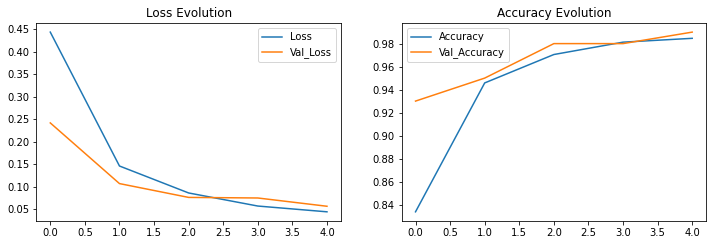

In [40]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')
plt.savefig('lossCurve')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')
plt.savefig('accuracyCurve')



In [41]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

2790/2790 [==============================] - 96s 34ms/step - loss: 0.1447 - accuracy: 0.9624
Test Accuracy: 96.24%
262/262 [==============================] - 132s 504ms/step - loss: 0.0970 - accuracy: 0.9940
Train Accuracy: 99.40%


In [42]:
from keras.utils.np_utils import to_categorical 
num_classes=len(test.class_indices)

test_labels = test.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes) 
test_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [43]:
from sklearn.metrics import confusion_matrix, classification_report

# rounded_labels=np.argmax(test, axis=1)

pred = model.predict(test)
# pred = np.argmax(predictions, axis=1)

y_pred=np.argmax(pred, axis=1)
y_test=np.argmax(test_labels, axis=1)


cnf_matrix=confusion_matrix(y_test, y_pred)

pd.DataFrame(classification_report(y_test,y_pred,output_dict=True))


,0,1,2,accuracy,macro avg,weighted avg
precision,0.925662,0.963455,1.000000,0.962007,0.963039,0.963039
recall,0.977419,0.935484,0.973118,0.962007,0.962007,0.962007
f1-score,0.950837,0.949264,0.986376,0.962007,0.962159,0.962159
support,930.000000,930.000000,930.000000,0.962007,2790.000000,2790.000000


In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[909  21   0]
 [ 60 870   0]
 [ 13  12 905]]


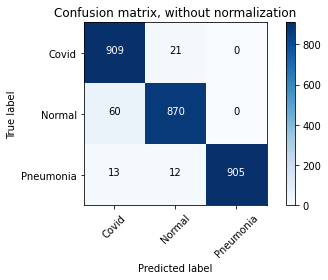

In [45]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Covid', 'Normal', 'Pneumonia'],
                      title='Confusion matrix, without normalization')
plt.savefig('confusion matrix')
